In [18]:
import torch
torch.cuda.is_available()

True

In [19]:
!wget -O "dataset.zip" "https://firebasestorage.googleapis.com/v0/b/uva-landmark-images.appspot.com/o/dataset.zip?alt=media"

--2020-04-20 16:11:47--  https://firebasestorage.googleapis.com/v0/b/uva-landmark-images.appspot.com/o/dataset.zip?alt=media
Resolving firebasestorage.googleapis.com (firebasestorage.googleapis.com)... 74.125.133.95, 2a00:1450:400c:c0a::5f
Connecting to firebasestorage.googleapis.com (firebasestorage.googleapis.com)|74.125.133.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 397174132 (379M) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>] 378.77M   114MB/s    in 3.3s    

2020-04-20 16:11:50 (114 MB/s) - ‘dataset.zip’ saved [397174132/397174132]



In [0]:
%%capture
!unzip "/content/dataset.zip"

In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.data.sampler import SubsetRandomSampler

plt.ion()

data_transforms = transforms.Compose([
        transforms.Resize(360), 
        transforms.CenterCrop(224), 
        transforms.ToTensor(), 
        transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                          std = [0.229, 0.224, 0.225])
    ])

data_dir = '/content/dataset'

image_datasets = datasets.ImageFolder(os.path.join(data_dir), transform = data_transforms)


In [0]:
import random

len(image_datasets)
indices = list(range(len(image_datasets)))
random.shuffle(indices)
split = int(np.floor(0.2 * len(image_datasets)))
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


In [23]:
print(len(train_sampler))
print(len(valid_sampler))

11429
2857


In [0]:
dataloaders = {'train': torch.utils.data.DataLoader(image_datasets, batch_size=32,
                                             shuffle=False, num_workers=4,
                                             sampler = train_sampler),
               'val': torch.utils.data.DataLoader(image_datasets, batch_size=32,
                                             shuffle=False, num_workers=4,
                                             sampler = valid_sampler)}
dataset_sizes = {'train': len(train_sampler), 'val': len(valid_sampler)}
class_names = image_datasets.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [25]:
torch.cuda.is_available()

True

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated




In [27]:
inputs, classes = next(iter(dataloaders['train']))
i = 0 
while i < len(classes):
  imshow(inputs[i], title=class_names[classes[i]])
  i+=1


Output hidden; open in https://colab.research.google.com to view.

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    if type(outputs) == tuple:
                        outputs, _ = outputs
                    # print(type(outputs))
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [0]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [30]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=7)


Epoch 0/6
----------
train Loss: 1.2061 Acc: 0.6833
val Loss: 0.4527 Acc: 0.8894

Epoch 1/6
----------
train Loss: 0.2964 Acc: 0.9324
val Loss: 0.2753 Acc: 0.9370

Epoch 2/6
----------
train Loss: 0.1257 Acc: 0.9742
val Loss: 0.2430 Acc: 0.9433

Epoch 3/6
----------
train Loss: 0.0595 Acc: 0.9887
val Loss: 0.2342 Acc: 0.9440

Epoch 4/6
----------
train Loss: 0.0344 Acc: 0.9942
val Loss: 0.2297 Acc: 0.9468

Epoch 5/6
----------
train Loss: 0.0207 Acc: 0.9969
val Loss: 0.2351 Acc: 0.9450

Epoch 6/6
----------
train Loss: 0.0139 Acc: 0.9989
val Loss: 0.2353 Acc: 0.9471

Training complete in 32m 3s
Best val Acc: 0.947147


In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


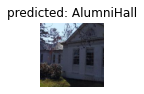

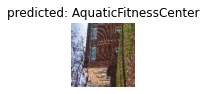

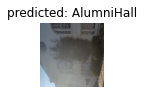

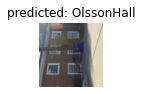

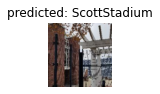

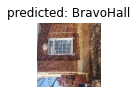

In [32]:
visualize_model(model_ft)

In [0]:
from PIL import Image

def imshow(inp, txt, titles=None, predictions=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(txt)

def viz_test_img(path):
  img_pil = Image.open(path)


  preprocessFn = transforms.Compose(
      [transforms.Resize(256), 
      transforms.CenterCrop(224), 
      transforms.ToTensor(), 
      transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                            std = [0.229, 0.224, 0.225])])
  inputs =  preprocessFn(img_pil).unsqueeze(0)

  was_training = model_ft.training
  model_ft.eval()
  images_so_far = 0
  fig = plt.figure()

  with torch.no_grad():
    inputs = inputs.to(device)
    outputs = model_ft(inputs)
    _, preds = torch.max(outputs, 1)
    imshow(inputs.cpu().data[0], class_names[preds])


In [0]:
%%capture
!wget -O "testTh.jpg" "https://www.studenthealth.virginia.edu/sites/studenthealth.virginia.edu/files/Thornton_Hall_Spring_17_SS_01.jpg"

!wget -O "testRot.jpg" "https://upload.wikimedia.org/wikipedia/commons/b/bf/Rotunda_UVa_from_the_south_east.jpg"

!wget -O "testCh.jpg" "https://eventplanning.odos.virginia.edu/sites/eventplanning.odos.virginia.edu/files/chapel_0.jpg"

!wget -O "testR.jpg" "https://media.glassdoor.com/l/d7/f4/d2/5d/rice-hall-computer-science.jpg"

!wget -O "testNw.jpg" "https://eventplanning.odos.virginia.edu/sites/eventplanning.odos.virginia.edu/files/newcomb.jpg"

!wget -O "testNC.jpg" "https://news.virginia.edu/sites/default/files/styles/uva_basic_article/public/article_image/14697_photo_1_high_res.jpg"

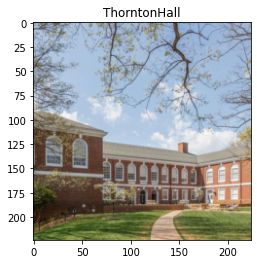

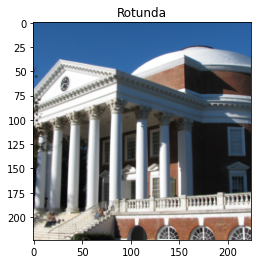

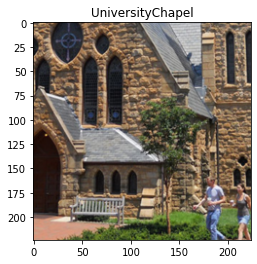

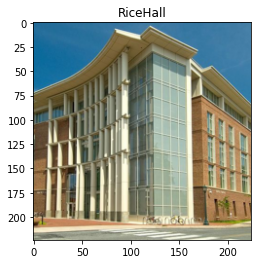

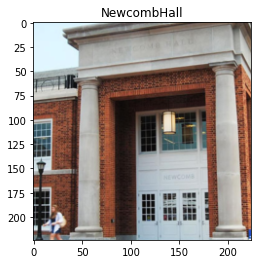

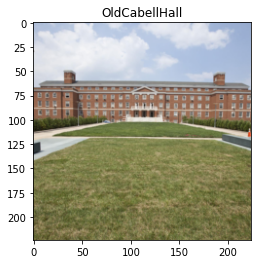

In [35]:
viz_test_img("./testTh.jpg")
viz_test_img("./testRot.jpg")
viz_test_img("./testCh.jpg")
viz_test_img("./testR.jpg")
viz_test_img("./testNw.jpg")
viz_test_img("./testNC.jpg")